In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
import glob
import sys
import pickle
from scipy import interpolate ,optimize
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm_notebook as tqdm#from tqdm import tqdm
#look at fixing later 
import warnings
warnings.filterwarnings('ignore')

#import functions from file in path 
sys.path.insert(0, '/home/ben/Documents/Bonn-uni/internship/python_code/functions')
#from functions2 import MS_finder2
from data_loading import load_masses, load_models
#sys.path.insert(0, '/home/ben/Documents/Bonn-uni/internship/python_code/Interpolation')
from interpolation import M_V_T_interp, MVT_interp_setup, v_over_vcrit_interp, interp_vcrit_min

data_dir='/home/ben/Documents/Bonn-uni/internship/takeaway_data/' #'/users/bhastings/internship/data/MW/' # #

file_ext= '.dat2'

In [2]:


data_files, mass_list= load_masses(data_dir, 25)

data_df=load_models(data_files)

vmax_dict={}
for m in mass_list:
    di=data_df[data_df.M == m ]
    vmax=np.unique(di['V']).max()
    vmax_dict[m]=di['V_init'][di['V']== vmax].iloc[0]

masses of models :
[ 3.  5.  7.  9. 10. 12. 15. 20. 25.]
working on file 112 / 112

# Interpolate V-M-T # 

In [3]:

v_T_interp= MVT_interp_setup(data_df, mass_list)
print M_V_T_interp(4,450, v_T_interp)

232340057.2630242


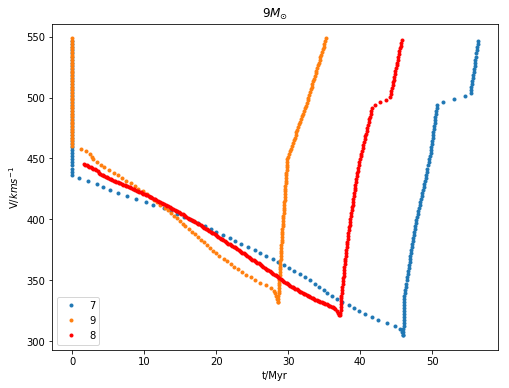

In [4]:
v_critmin_boundary=  pickle.load(open('v_critmin_boundary.pk', 'rb'))
res_df=interp_vcrit_min(8, 0.7, data_df,v_critmin_boundary, vmax_dict, v_T_interp )
   


In [ ]:
t=0
m_i=15
Be_value=0.7

    
plot_df=pd.DataFrame()
for Be_value in (0.6,0.7,0.8,0.9,0.99):
    plot_arr=np.array([])
    for m_i in [15]:#mass_list:
        sys.stdout.write ('\r'+ str(Be_value)+'--'+str(m_i))
        dm=data_df[data_df.M ==m_i]
        #v_crit_min_arr=np.array([[]])

        #for t in np.linspace(0,100, 100): # times in Myr 
        #    t=t*1e6
        dg=pd.DataFrame()
        for vi in np.unique(dm['V_init'])[1:]:
            di= dm[(dm['V_init']==vi) & (dm['t/Tms']<0.99)  ]
            ti=((di['V/Vcrit']-(Be_value)).abs()).argmin()
            
            if di['V/Vcrit'].iloc[ti]> 0.99*Be_value:
                dn= di.iloc[ti]
                dg=dg.append(dn)

            
        plt.plot(dg['1:t[s]']/1e6, dg['V_init'], 'ko')
        plt.show()
        straight_line1=interpolate.interp1d(dg['V_init'], dg['V/Vcrit'],
                                                   bounds_error=False, assume_sorted=True)
      

#print plot_df.to_string()
print 'DONE'
#plot_df.to_pickle('./plot_df.pk')

In [ ]:


s=v_over_vcrit_interp(data_df,20, 200, v_T_interp, True)


In [ ]:

plot_df=pd.read_pickle('./plot_df.pk')
grouped = plot_df.groupby(['Be_value','M'])

vcritmin_dict={}

for g,group in grouped: 
    x=group['M']
    y=group['V_critmin'].min(skipna=True)
    #print g, y
    vcritmin_dict[g[0], g[1]]= y
    
#print vcritmin_dict



In [ ]:
B_vals=([0.6,0.7,0.8,0.9,0.99])
crit_rot_data={}

    
for M in tqdm(np.flip(mass_list)[0:2]):
        #message=str(B)+ '---'+ str(M)
        #sys.stdout.write ('\r'+ message)
        
    v_minM=vcritmin_dict[0.6,M] 
    if np.isnan(v_minM) ==True:
            
        continue 
    v_maxM=vmax_dict[M]
    v_vals=tqdm(np.linspace(v_minM,v_maxM, 50))
    crit_times=map(lambda v: v_over_vcrit_interp(data_df,M, v, v_T_interp, False), v_vals)
    crit_rots_df=pd.DataFrame()
    for r in  crit_times:
        #first time star is faster than B
       

        crit_rots_df=crit_rots_df.append(r)
                #crit_rots_df=crit_rots_df.append(pd.DataFrame([[M,v_i,t_1,t_2]], 
                #                                       columns=['M','V_init', 't1', 't2']))

    crit_rots_df.reset_index(drop=True, inplace=True)
    crit_rot_data[M]= crit_rots_df
    #v_crit_min_master[B]= crit_rot_data
        
        #plt.plot( crit_rots_df['t']/1e6,crit_rots_df['V_init'], 'o')
        #plt.plot( crit_rots_df['t2']/1e6,crit_rots_df['V_init'], 'o')
        #plt.title(M)
        #plt.show()


#pickle.dump( v_crit_min_master, open( "crit_rot_data2.pk", "wb" ) )

In [ ]:
B_vals=([0.6,0.7,0.8,0.9,0.99])
v_crit_min_master={}
for B in [0.6]:#B_vals:
    crit_rot_data={'B':B}
    for M in [10,12]:#tqdm(np.flip(mass_list)):
        #message=str(B)+ '---'+ str(M)
        #sys.stdout.write ('\r'+ message)
        
        v_minM=vcritmin_dict[B,M] 
        if np.isnan(v_minM) ==True:
            
            continue 
        v_maxM=vmax_dict[M]
        v_minM=0.9*v_minM
        v_vals=tqdm(np.linspace(v_minM,v_maxM, 50))
        crit_times=map(lambda v: v_over_vcrit_interp(data_df,M, v, v_T_interp, False), v_vals)
        crit_rots_df=pd.DataFrame()
        for r in  crit_times:
            #first time star is faster than B
            crit_rotators=r[r['V/Vcrit']>B]

            if crit_rotators.empty == False:
                v_i=r['V_init'][0]
                t_1=r[r['V/Vcrit']>B]#.iloc[0]['t']
                #t_2=r[r['V/Vcrit']>B].iloc[-1]['t']
                #print 'V_i=',np.round(v_i,2),'t_1=' , np.round(t_1/1e6,3) , 't_2=', np.round( t_2/1e6,3)

                crit_rots_df=crit_rots_df.append(t_1)
                #crit_rots_df=crit_rots_df.append(pd.DataFrame([[M,v_i,t_1,t_2]], 
                #                                       columns=['M','V_init', 't1', 't2']))

        crit_rots_df.reset_index(drop=True, inplace=True)
        crit_rot_data[M]= crit_rots_df
        v_crit_min_master[B]= crit_rot_data
        
        #plt.plot( crit_rots_df['t']/1e6,crit_rots_df['V_init'], 'o')
        #plt.plot( crit_rots_df['t2']/1e6,crit_rots_df['V_init'], 'o')
        #plt.title(M)
        #plt.show()


#pickle.dump( v_crit_min_master, open( "crit_rot_data3.pk", "wb" ) )

In [6]:
v_crit_min_master= pickle.load(open('crit_rot_data2.pk', 'rb'))

In [7]:
v_critmin_boundary={}
for M in ((mass_list)):#np.sort(v_crit_min_master[B].keys()):
    #plt.clf()
    for B in np.sort(v_crit_min_master.keys()):
        
        if M in v_crit_min_master[B]:
            crit_rots_df=v_crit_min_master[B][M]

        #else :
        #    continue
        #crit_rots_df= crit_rot_data[M]
            vcritmin_df=pd.DataFrame()
            for vi in np.unique(crit_rots_df['V_init']):
                di=crit_rots_df[crit_rots_df['V_init'] == vi ]
                di.reset_index(drop=True, inplace=True)
                x=di['t']
                y=di['V_init']
                T= di['t/T']
                ix=x.argmax()
                im= np.argmin(x)

                #plt.plot(x, y, 'rs',alpha=0.05, label='_nolegend_')
                #plt.plot(x.loc[im], y.loc[im], 'g.')


                if np.isnan(ix) == False:
                    vcritmin_df=vcritmin_df.append(pd.DataFrame([[x.loc[ix],T.loc[ix], y.loc[ix]]], columns=['t','t/T', 'Vcrit_min']))
                if np.isnan(im) ==False :
                    vcritmin_df=vcritmin_df.append(pd.DataFrame([[x.loc[im], T.loc[im],y.loc[im]]], columns=['t','t/T', 'Vcrit_min']))


            vcritmin_df=vcritmin_df.sort_values(['t', 'Vcrit_min'], ascending=[True, False])

            v_critmin_boundary[B,M]= vcritmin_df

            x=vcritmin_df['t/T']
            y=vcritmin_df['Vcrit_min']
            #x,y=sort_into_line(x,y)
            #plt.fill_between( x/1e6, y,crit_rots_df['V_init'].max(), alpha=1, label=B)
            #plt.axvline(0)
            plt.plot(x,y, 'o-',label='_nolegend_' )
            plt.title(str(M) + str('$M_{\odot}$'))
            plt.legend(loc='lower left')
            plt.xlabel('t/Myr')
            plt.ylabel('V/$kms^{-1}$')
#plt.show()
    #plt.savefig(str(M)+'.png', dpi=300)
    


In [ ]:
def interp_vcrit_min(m_i, B_i, data_df,v_critmin_boundary, vmax_dict ):
#m_i=5.6
#B_i=0.7
    m1= data_df[data_df['M'] <=  m_i].M.max()
    m2= data_df[data_df['M'] >  m_i].M.min()

    interp_lines={}

    for M in [m1,m2]:#np.sort(v_crit_min_master[B].keys()):
        #plt.clf()
        for B in [B_i]:#np.sort(v_crit_min_master.keys()):
            #print v_critmin_boundary.keys(), B,M
            if (B,M) in v_critmin_boundary.keys():
                critmin_df=v_critmin_boundary[B,M]

            else :
                continue
            #crit_rots_df= crit_rot_data[M]

                #x=critmin_df['t/T']
                #y=critmin_df['Vcrit_min']

            x=critmin_df['t/T'][(critmin_df['t/T'] < critmin_df['t/T'].max()) & 
                                    (critmin_df['t/T'] > critmin_df['t/T'].min())]
            y=critmin_df['Vcrit_min'][(critmin_df['t/T'] < critmin_df['t/T'].max()) & 
                                    (critmin_df['t/T'] > critmin_df['t/T'].min())]

            straight_line=interpolate.interp1d(x,y,bounds_error=True, assume_sorted=True)

            interp_lines[M]= [straight_line, [x.min(),x.max()]]
            #print x.min(),x.max()
            #plt.plot(np.linspace(x.min(),x.max(),100), straight_line(np.linspace(x.min(),x.max(),100)))

            plt.plot(critmin_df['t']/1e6,critmin_df['Vcrit_min'], '.',label=M )
            plt.title(str(M) + str('$M_{\odot}$'))
            plt.legend(loc='lower left')
            plt.xlabel('t/Myr')
            plt.ylabel('V/$kms^{-1}$')
    #plt.show()

    a=interp_lines[m1]
    b=interp_lines[m2]
    mins=[a[1][0],b[1][0] ]
    maxs=[a[1][1],b[1][1] ]

    t_vals=np.linspace(max(mins), min(maxs), 200)

    a=interp_lines[m1][0]
    b=interp_lines[m2][0]
    res_df=pd.DataFrame()
    for t_i in t_vals:
        y=[a(t_i), b(t_i)]

        straight_line=interpolate.interp1d([m1,m2],y,bounds_error=True, assume_sorted=True)

        T= M_V_T_interp(m_i,straight_line(m_i), v_T_interp)

        res_df=res_df.append(pd.DataFrame([[t_i*T,straight_line(m_i), t_i]], columns=['t', 'V_init', 't/T']))



    v_vals=np.linspace(res_df['V_init'].min(), vmax_dict[m1], 100)
    for v_i in v_vals: 
        T=M_V_T_interp(m_i,v_i, v_T_interp)

        res_df=res_df.append(pd.DataFrame([[0.99*T,v_i, 0.99]], 
                                          columns=['t', 'V_init', 't/T']))

    res_df.reset_index(drop=True, inplace=True)
    plt.plot(res_df['t']/1e6,res_df['V_init'], 'r.' , label=m_i)
    plt.legend()
    plt.show()

    return res_df


res_df=interp_vcrit_min(8, 0.7, data_df,v_critmin_boundary, vmax_dict )

t=40e6

ik=(res_df['t']-t).abs().argmin()
print res_df['V_init'].iloc[ik],  res_df['t'].iloc[ik]

In [ ]:
a=interp_lines[m1][0]
t_vals= np.linspace(0.1,0.8, 100)
print a(t_vals)

In [ ]:
x.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

print pd.concat([x,y], axis=1).values[0][1]
plt.plot(x, y, 'o')
plt.show()


def distance(P1, P2):
    """
    This function computes the distance between 2 points defined by
     P1 = (x1,y1) and P2 = (x2,y2) 
    """

    return ((P1[0] - P2[0])**2 + (P1[1] - P2[1])**2) ** 0.5


def optimized_path(coords, start=None):
    """
    This function finds the nearest point to a point
    coords should be a list in this format coords = [ [x1, y1], [x2, y2] , ...] 

    """
    if start is None:
        start = coords[0]
    pass_by = coords
    path = [start]
    pass_by.remove(start)
    while pass_by:
        nearest = min(pass_by, key=lambda x: distance(path[-1], x))
        path.append(nearest)
        pass_by.remove(nearest)
    return path

# define a start point
start = [pd.concat([x,y], axis=1).values[0][0], pd.concat([x,y], axis=1).values[0][1]]

path = optimized_path(pd.concat([x,y], axis=1).values.tolist(),start)


#print np.array(path)[:,1]

xx=np.array(path)[:,0]
yy= np.array(path)[:,1]

plt.plot(xx,yy, 'o-')
plt.show()

In [ ]:
def sort_into_line(x,y):
    plt.plot(x,y)
    plt.show()
    ymn=y.argmin()
    
    x1=x[x< x[ymn]]
    y1=y[x< x[ymn]]

    print x.loc[ymn], y.loc[ymn]
    dc=pd.concat([x1,y1], axis=1)
    print dc.columns.tolist()
    dc.sort_values(['Vcrit_min'], inplace=True, ascending=False)

    plt.plot(dc['t'],dc['Vcrit_min'], 'k')
    plt.show()

    x2=x[x>x[ymn]]
    y2=y[x>x[ymn]]

    dc2=pd.concat([x2,y2], axis=1)

    dc2.sort_values(['Vcrit_min'], inplace=True)

    #plt.plot(dc2['t'],dc2['Vcrit_min'], 'k')
    #plt.show()

    dc3=dc.append(dc2)

    plt.plot(dc3['t'],dc3['Vcrit_min'], 'k')
    plt.show()
    
    return dc3['t'], dc3['Vcrit_min']

b,k=sort_into_line(x,y)

plt.plot(b,k)
plt.show()

print y.min()

In [ ]:
print v_crit_min_master.keys()


for M in (mass_list):#np.sort(v_crit_min_master[B].keys()):
    print M,
    #plt.clf()
    plot_arr_df=pd.DataFrame()
    for B in np.sort(v_crit_min_master.keys()):
        
        if M in v_crit_min_master[B]:
            crit_rots_df=v_crit_min_master[B][M]

        else :
            continue
        #crit_rots_df= crit_rot_data[M]
        print crit_rots_df.columns.tolist()
        vcritmin_df=pd.DataFrame()
        #for vi in np.unique(crit_rots_df['V_init']):
        #    di=crit_rots_df[crit_rots_df['V_init'] == vi ]
        #    x=di['t']
        #    y=di['V_init']

            #ix=x.argmax()
            #im= x.argmin()

            
        
        #    for ti in np.unique(di['t']):
        #        plot_arr_df=plot_arr_df.append(di)
                
        x= crit_rots_df['t/T']#plot_arr_df['t']
        y= crit_rots_df['V/Vcrit_init']#plot_arr_df['V_init']
        maxT= x.max()
        plt.plot(x/maxT, y, 's', markersize=3, label=M)
       
        plt.title(str(M) + str('$M_{\odot}$') )#+'  $V/V_{crit}$ > '+ str(B))
        #plt.legend(loc='lower left')
        plt.xlabel('t/Myr')
        plt.ylabel('V/$kms^{-1}$')
        plt.legend(markerscale=3)
plt.show()
            #plt.savefig('./img/'+str(int(M))+'/'+str(int(M))+'-'+str(int(100*B))+'.png', dpi=300)
        #plt.savefig('./img/'+str(int(M))+'.png', dpi=300)
#plt.clf()
        
            
            
    #plt.savefig(str(M)+'.png', dpi=300)
    
print 'DONE'

In [ ]:
print v_crit_min_master.keys()


for M in (mass_list):#np.sort(v_crit_min_master[B].keys()):
    print M,
    #plt.clf()
    plot_arr_df=pd.DataFrame()
    for B in np.sort(v_crit_min_master.keys()):
        
        if M in v_crit_min_master[B]:
            crit_rots_df=v_crit_min_master[B][M]

        else :
            continue
        #crit_rots_df= crit_rot_data[M]
        print crit_rots_df.columns.tolist()
        vcritmin_df=pd.DataFrame()
        #for vi in np.unique(crit_rots_df['V_init']):
        #    di=crit_rots_df[crit_rots_df['V_init'] == vi ]
        #    x=di['t']
        #    y=di['V_init']

            #ix=x.argmax()
            #im= x.argmin()

            
        
        #    for ti in np.unique(di['t']):
        #        plot_arr_df=plot_arr_df.append(di)
                
        x= crit_rots_df['t/T']#plot_arr_df['t']
        y= crit_rots_df['V/Vcrit_init']#plot_arr_df['V_init']
        maxT= x.max()
        plt.plot(x/maxT, y, 's', markersize=3, label=B)
       
        plt.title(str(M) + str('$M_{\odot}$') )#+'  $V/V_{crit}$ > '+ str(B))
        #plt.legend(loc='lower left')
        plt.xlabel('t/T')
        plt.ylabel('V/$V_{crit}$')
        plt.legend(markerscale=3)
    plt.show()
            #plt.savefig('./img/'+str(int(M))+'/'+str(int(M))+'-'+str(int(100*B))+'.png', dpi=300)
        #plt.savefig('./img/'+str(int(M))+'.png', dpi=300)
#plt.clf()
        
            
            
    #plt.savefig(str(M)+'.png', dpi=300)
    
print 'DONE'

In [ ]:
print len(x), len(y)

In [ ]:
m_i=12.4
m1= data_df[data_df['M'] <=  m_i].M.max()
m2= data_df[data_df['M'] >  m_i].M.min()
print m1, m2

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
plt.clf()

m_i=4


m1= data_df[data_df['M'] <=  m_i].M.max()
m2= data_df[data_df['M'] >  m_i].M.min()

vcritmin_arr=[]
plot_arr_df=pd.DataFrame()

for M in [m1,m2]:#np.sort(v_crit_min_master[B].keys()):
    print M, v_crit_min_master.keys()
    #plt.clf()
    
    for B in np.sort(v_crit_min_master.keys()):
        
        if M in v_crit_min_master[B]:
            crit_rots_df=v_crit_min_master[B][M]

        else :
            continue
        
        
        for t_i in np.unique(crit_rots_df['t/T'])[0:10]: 
            
            x= crit_rots_df['V/Vcrit'][crit_rots_df['t/T']==t_i]   #['t']#plot_arr_df['t']
            y= crit_rots_df['V_init'][crit_rots_df['t/T']==t_i]    #plot_arr_df['V_init']
            print crit_rots_df.columns.tolist()
            print y
            vcritmin_arr=np.append(vcritmin_arr,y.iloc[0])
            plot_arr_df=plot_arr_df.append(pd.DataFrame([[M,t_i,y.iloc[0] ]], columns=['M', 't/T', 'V_critmin']))
            plot_arr_df.reset_index(drop=True, inplace=True)
            
            #plt.plot(M, y.iloc[0], 'X')
            
            
            #plt.plot(x, y, '.', markersize=3, label=M)

#for t_i in np.unique(plot_arr_df['t/T']):             
    
#    dv=plot_arr_df[plot_arr_df['t/T']== t_i]
    

#    straight_line=interpolate.interp1d( dv['M'],dv['V_critmin'],bounds_error=True, assume_sorted=True)
    #print 'M= ', m_i, 'Vcritmin= ', straight_line(m_i), 't/T= ', np.round(t_i,3), 't= ', np.round(t_i * M_V_T_interp(m_i,straight_line(m_i), v_T_interp),2)/1e6
#    x=t_i * M_V_T_interp(m_i,straight_line(m_i), v_T_interp)
#    y=straight_line(m_i)
#    plt.plot(x/1e6,y, 'k.')
    
    #plt.plot(np.linspace(m1,m2,20), straight_line(np.linspace(m1,m2,20)))
    #plt.plot(dv['M'],dv['V_critmin'], 'X')
    
    #plt.title(t_i)
#plt.show()
    
#straight_line=interpolate.interp1d( [m1,m2],vcritmin_arr,bounds_error=True, assume_sorted=True)
#print 'M= ', m_i, 'Vcritmin= ', straight_line(m_i), 't/T= ', np.round(t_i,3), 't= ', np.round(t_i * M_V_T_interp(m_i,straight_line(m_i), v_T_interp),2)/1e6


#plt.plot(np.linspace(m1,m2,20), straight_line(np.linspace(m1,m2,20)))
#plt.title(t_i)#+'  $V/V_{crit}$ > '+ str(B))
    #plt.legend(loc='lower left')
    #plt.xlabel('t/Myr')
#plt.ylabel('V/$kms^{-1}$')
#plt.legend(markerscale=2)
#plt.show()
        #plt.savefig('./img/'+str(int(M))+'/'+str(int(M))+'-'+str(int(100*B))+'.png', dpi=300)
    #plt.savefig('./img/'+str(int(M))+'.png', dpi=300)
    #plt.clf()
        
            
            
    #plt.savefig(str(M)+'.png', dpi=300)
    
print 'DONE'

In [ ]:
v_grid= np.unique(plot_arr_df['v'])
t_grid= np.linspace(0,np.unique(plot_arr_df['t']).max(), 10*len(np.unique(plot_arr_df['t'])))

for v in v_grid: 
    for t in t_grid: 
        dk= plot_arr_df[plot_arr_df== v]
        print (dk)#.abs().min()

In [ ]:
#plot V_critmin against m for a point in time 
#crit_rot_data= pickle.load('./crit_rot_data.pk')
t=5e6
def V_critmin_interp(t, m_i):
    m_V_critmin_df=pd.DataFrame()
    for m in np.sort(crit_rot_data.keys()):
        di= crit_rot_data[m]

        di.reset_index(drop=True, inplace=True)

        ti=((di['t1']-(t)).abs()).argmin()
        v_critmin= di.iloc[ti]['V_init']


        m_V_critmin_df=m_V_critmin_df.append(pd.DataFrame([[m,v_critmin]], columns=['M', 'V_critmin']))

        #ti=((di['t2']-(t)).abs()).argmin()
        #v_critmin= di.iloc[ti]['V_init']
        #plt.plot(m, v_critmin, 'go')

    straight_line1=interpolate.interp1d(x=m_V_critmin_df['M'], y=m_V_critmin_df['V_critmin'],
                                                       bounds_error=True, assume_sorted=True)

    m_arr=np.linspace(10,12,50)
    plt.plot(m_arr, straight_line1(m_arr))
    plt.plot(m_V_critmin_df['M'], m_V_critmin_df['V_critmin'], 'ko')  
    plt.show()
    
    #print straight_line1(14)
    
    return straight_line1(m_i)

print V_critmin_interp(11e6, 10.5)

In [ ]:
print m_V_critmin_df

In [ ]:
v_als=[550,535,525]

a=v_over_vcrit_interp(data_df,25, v_als[0], v_T_interp, False) #12M initially at v/vcrit=0.5
b=v_over_vcrit_interp(data_df,25, v_als[1], v_T_interp, False) # initially at v/vcrit=0.5
c=v_over_vcrit_interp(data_df,25, v_als[2], v_T_interp, False)# initially at v/vcrit=0.5

plt.plot( a['t/T'],a['V/Vcrit'], 'r-', label=v_als[0])
plt.plot( b['t/T'],b['V/Vcrit'], 'k-', label=v_als[1])
plt.plot( c['t/T'],c['V/Vcrit'], label=v_als[2])
plt.legend()
plt.xlabel('t/T')
plt.ylabel('V/Vcrit')
plt.axhline(0.6)
plt.show()

In [ ]:
plt.clf()
plt.plot( a['t/T'],a['V/Vcrit'], 'r-', label=v_als[0])
plt.plot( b['t/T'],b['V/Vcrit'], 'k-', label=v_als[1])
plt.plot( c['t/T'],c['V/Vcrit'], label=v_als[2])
plt.legend()
plt.title('Interpolated $V/V_{crit}$ curves for 25$ M_{\odot}$ models')
plt.xlabel('t/T')
plt.ylabel('V/Vcrit')
plt.axhline(0.6, linestyle='--', color='k')
#plt.show()
plt.savefig('25-curves.png', dpi=300)

In [ ]:

plot_df=pd.read_pickle('./plot_df.pk')




#print plot_df.head(100)

In [ ]:
B_vals=([0.6,0.7,0.8,0.9,0.99])
#v_crit_min_master={}
#for B in [0.6]:#B_vals:
    
for M in [10]:#tqdm(np.flip(mass_list)):
    #message=str(B)+ '---'+ str(M)
    #sys.stdout.write ('\r'+ message)
        
    v_minM=vcritmin_dict[B,M] 
    if np.isnan(v_minM) ==True:
            
        continue 
    v_maxM=vmax_dict[M]
    v_minM=0.5*v_maxM
    v_vals=tqdm(np.linspace(v_minM,v_maxM, 50))
    crit_times=map(lambda v: v_over_vcrit_interp(data_df,M, v, v_T_interp, False), v_vals)
    crit_rots_df=pd.DataFrame()
    for r in  crit_times:
        #first time star is faster than B

        crit_rots_df=crit_rots_df.append(r)
            
        crit_rots_df.reset_index(drop=True, inplace=True)
        
        #crit_rot_data[M]= crit_rots_df
        #v_crit_min_master[B]= crit_rot_data
        
        #plt.plot( crit_rots_df['t']/1e6,crit_rots_df['V_init'], 'o')
        #plt.plot( crit_rots_df['t2']/1e6,crit_rots_df['V_init'], 'o')
        #plt.title(M)
        #plt.show()


#pickle.dump( v_crit_min_master, open( "crit_rot_data3.pk", "wb" ) )

In [ ]:
for t_i in tqdm(np.unique(crit_rots_df['t'])):
    dj= crit_rots_df[crit_rots_df['t/T']== t_i]
    for v_i in np.unique(dj['V_init']):
        dk= dj[dj['V_init'] ==v_i]
        
        if dk['V/Vcrit'].any() >0.6 : 
            plt.plot(t_i,v_i, 'ks')
            
plt.show()

In [ ]:
grouped = plot_df.groupby(['Be_value','M'])

plot2=pd.DataFrame()

for g,group in grouped: 
    y_vals=[]
    #print group
    x=group['M']
    y=group['V_critmin'].min(skipna=True)
    y_vals=y_vals.append(y)
    plot2=plot2.append(pd.DataFrame([[g[1], y, g[0]]], columns=['M', 'V_critmin', 'Be_value']))
    
#print plot_df
#print plot2
grouped = plot2.groupby(['Be_value'])
for g,group in grouped: 
    x=group.M
    y=group['V_critmin']
    
    plt.plot(x,y,'o-', label=g)
    
    
plt.xlabel(r'$M_{\odot}$')
plt.ylabel(r'$V_{init}/kms^{-1}$')
plt.title('Min. $V_{init}$ for $V/V_{crit}$ to reach certain value')

plt.legend()
#plt.savefig('V_crit-min_plot4.png', dpi=300)
plt.show()



In [ ]:
interp_df=pd.DataFrame()
v_crit_interpolation={}
for m in  mass_list:
    dx=data_df[data_df.M ==m]
    for vi in np.unique(dx['V_init'])[1:]:
        dl=dx[(dx['V_init']==vi)]
        x=dl['V_crit'][0:10].mean()
        y=dl['V_init']
        #print m, vi,x
        #plt.plot(vi,x, 'o')
        interp_df=interp_df.append(pd.DataFrame([[m,vi,x]], columns=['M', 'V_init', 'V_crit_init']))
        
    #plt.title(m)    
    #plt.ylim(0,1.05)
    #plt.axhline(0.9)
    #plt.xlabel('V initial')
    #plt.ylabel('V_crit initial')
    #plt.show()
interp_df.head()

grouped = interp_df.groupby(['M'])
for g,group in grouped: 
    x=group['V_init']
    y=group['V_crit_init']
    straight_line1=interpolate.interp1d(x,y,
                                        bounds_error=False, assume_sorted=True)
    
    vs=np.linspace(0,600,100)
    v_crit_interpolation[g]= straight_line1
    plt.plot(vs, straight_line1(vs))
    plt.title(g)
    plt.show()
    
    
print v_crit_interpolation

In [ ]:

interp_vcrit= lambda x: v_crit_interpolation[x['M']](x['V_critmin'])
plot_df.reset_index(inplace=True)
for index, row in plot_df.iterrows():
    #print index
    #print v_crit_interpolation[row.M](row['V_critmin'])
    #row['Vcrit_init']= v_crit_interpolation[row.M](row['V_critmin'])
    plot_df.set_value(index,'Vcrit_init', v_crit_interpolation[row.M](row['V_critmin']))
    
print plot_df.to_string()

In [ ]:
grouped = plot_df.groupby(['Be_value','M'])

plot2=pd.DataFrame()

for g,group in grouped: 
    x=group['M']
    idx=group['V_critmin'].argmin(skipna=True)
    if np.isfinite(idx):
        Vi=group['V_critmin'].loc[idx]
        Vc=group['Vcrit_init'].loc[idx]
        y=Vi/Vc
    else:
        y=np.nan
        
    plot2=plot2.append(pd.DataFrame([[g[1], y, g[0]]], columns=['M', 'V/V_critmin', 'Be_value']))

#print plot_df
#print plot2.to_string()
grouped = plot2.groupby(['Be_value'])
for g,group in grouped: 
    x=group.M
    y=group['V/V_critmin']
    
    plt.plot(x,y,'o-', label=g)
    
    
plt.xlabel(r'$M_{\odot}$')
plt.ylabel(r'$V/V_{crit}$')
plt.title('Min. initial critical fraction for $V/V_{crit}$ to reach certain value')

plt.legend()
#plt.savefig('V_crit-min_plot3.png', dpi=300)
plt.show()


In [ ]:
for vi in np.unique(data_df['V'])[1:]:
    for m in  mass_list:
        dx=data_df[data_df.M ==m]
    
        dl=dx[(dx['V']==vi)]
        y=dl['V_crit'][0:10].mean()
        x=m
        #print m, vi,x
        plt.plot(x,y, 'o')
        
    plt.title(vi)    
    #plt.ylim(0,1.05)
    #plt.axhline(0.9)
    #plt.xlabel('V initial')
    #plt.ylabel('V_crit initial')
    plt.show()

In [ ]:
print data_df.head()

In [ ]:
#print MS_finder2('/home/ben/Documents/Bonn-uni/internship/takeaway_data/f10-50.mw.dat2')
print data_df.columns.tolist()
plt.clf()
for m in np.unique(data_df.M):
    
    dx=data_df[data_df.M ==m]
    for vi in np.unique(dx['V_init'])[1::4]:
        dl=dx[(dx['V_init']==vi) & (dx['t/Tms'] <0.99)]
        x=dl['t/Tms']
        y=dl['2:M/Msun'] *dl['5:R/Rsun']**2 #  /dl['2:M/Msun'].iloc[0]
        plt.plot(x,y, label=str(int(vi)) +' km/s')
        plt.title(m)    
        
    #plt.ylim(0,1.05)
    plt.xlabel(r'$t/T_{MS}$')
    plt.ylabel(r'$I$')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),ncol=5)
    
    plt.savefig('/home/ben/Documents/Bonn-uni/internship/plots/I/'+str(m)+'.png', dpi=300,bbox_inches='tight')
    plt.show()
    plt.clf()